In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from sklearn import metrics

In [3]:
class ChessData(torch.utils.data.Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path, index_col=0)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        inputs = row[:321].values.astype(np.float32)
        outputs = row[321:].values.astype(np.float32)

        return {'board': inputs, 'themes': outputs}


In [4]:
from torch.utils.data import DataLoader

batch_size = 256

chess_data_set = ChessData('cleaned_data/cleaned_train_puzzles.csv')

train_dataloader = DataLoader(chess_data_set, batch_size=batch_size, num_workers=4, persistent_workers=True, shuffle=True)

In [5]:
chess_validation_set = ChessData('cleaned_data/cleaned_validation_puzzles.csv')

validation_dataloader = DataLoader(chess_validation_set, batch_size=batch_size, num_workers=4, persistent_workers=True)

In [6]:
import torch.nn as nn

net = nn.Sequential(
    nn.Linear(321, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 28),
)


In [7]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_fn = nn.BCEWithLogitsLoss()

In [8]:
def get_loss():
    net.eval()
    total_loss = 0
    num_batches = 0

    for batch in tqdm(validation_dataloader):
        X = batch['board'].cuda()

        with torch.no_grad():
            pred = net(X)

        loss = loss_fn(pred, batch['themes'].cuda())
        total_loss += loss

        num_batches += 1

    total_loss /= num_batches

    return total_loss

In [12]:
net = net.cuda()
net.train()
loss_list = []

for epoch in range(100):
    epoch_train_loss = 0
    num_batches = 0

    for batch in tqdm(train_dataloader):
        X = batch['board'].cuda()

        pred = net(X)
        loss = loss_fn(pred, batch['themes'].cuda())
        epoch_train_loss += loss

        optim.zero_grad()
        loss.backward()

        optim.step()
  
        num_batches += 1

    epoch_train_loss /= num_batches
    epoch_val_loss = get_loss()

    loss_list.append((epoch_train_loss.item(), epoch_val_loss.item()))

    if epoch % 10 == 0:
        torch.save(net.state_dict(), f"model-epoch-{epoch}.pth")poch_{epoch}.pt"


100%|██████████| 607/607 [00:07<00:00, 83.07it/s]


In [13]:
print(loss_list)

[(0.11621426790952682, 0.11608059704303741), (0.11314386874437332, 0.11481372267007828), (0.11143128573894501, 0.1133381575345993), (0.11032752692699432, 0.11253196001052856), (0.10945125669240952, 0.11172646284103394), (0.10871517658233643, 0.11132432520389557), (0.10812272131443024, 0.1109839677810669), (0.10757213830947876, 0.11056101322174072), (0.10708900541067123, 0.11050701141357422), (0.10667644441127777, 0.11000456660985947), (0.10632311552762985, 0.1094871535897255), (0.10596102476119995, 0.10929131507873535), (0.10566320270299911, 0.10905773192644119), (0.10543186217546463, 0.10909953713417053), (0.10517869889736176, 0.10904468595981598), (0.10499005019664764, 0.10857576876878738), (0.10478757321834564, 0.10875070840120316), (0.10459117591381073, 0.10886844992637634), (0.10442940890789032, 0.10841260105371475), (0.10430274903774261, 0.10836179554462433), (0.1041153222322464, 0.1082465797662735), (0.10397464781999588, 0.10811379551887512), (0.10386678576469421, 0.108427479863

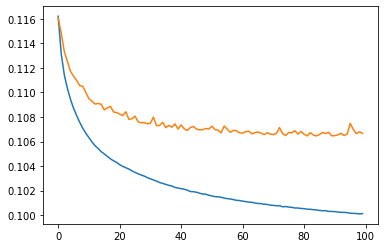

In [18]:
train_line = [loss[0] for loss in loss_list]
validation_line = [loss[1] for loss in loss_list]

plt.plot(train_line, label="train")
plt.plot(validation_line, label="validation")

In [19]:
torch.save(net.state_dict(), f"model-epoch-100.pth")